# CALCULATING APOLOGY:POSITIVE RATIO

In [4]:
import pandas as pd
import numpy as np
from scipy import stats


df = pd.read_csv('../data/rejection_analysis_extended.csv')
df_clean = df[df['status'] != 'ghosted'].copy()


## Method 1: Linear regression

Model: sentiment = baseline + (positive_effect × positives) + (apology_effect × apologies)


In [6]:
from sklearn.linear_model import LinearRegression

X = df_clean[['afinn_positive_count', 'apology_words']]
y = df_clean['vader_compound']

model = LinearRegression()
model.fit(X, y)

positive_coefficient = model.coef_[0]
apology_coefficient = model.coef_[1]

print("\n📊 LINEAR REGRESSION RESULTS:")
print("-"*80)
print(f"Baseline sentiment:      {model.intercept_:.4f}")
print(f"Positive word effect:    {positive_coefficient:+.4f} per word")
print(f"Apology word effect:     {apology_coefficient:+.4f} per word")

if apology_coefficient < 0:
    ratio = abs(apology_coefficient) / positive_coefficient
    print(f"\n🎯 CALCULATED RATIO: {ratio:.2f}:1")
    print(f"   → Each apology needs {ratio:.2f} positive words to neutralize")
else:
    print("\n⚠️ Unexpected: Apologies have positive effect!")



📊 LINEAR REGRESSION RESULTS:
--------------------------------------------------------------------------------
Baseline sentiment:      0.8278
Positive word effect:    +0.0251 per word
Apology word effect:     -0.1543 per word

🎯 CALCULATED RATIO: 6.16:1
   → Each apology needs 6.16 positive words to neutralize


# Method 2: Compare successful vs failed emails

In [7]:
successful_with_apologies = df_clean[
    (df_clean['apology_words'] > 0) & 
    (df_clean['vader_compound'] >= 0.90)
]

failed_with_apologies = df_clean[
    (df_clean['apology_words'] > 0) & 
    (df_clean['vader_compound'] < 0.50)
]

print("\n✅ SUCCESSFUL emails (despite apologies, score ≥ 0.90):")
print(f"{'Company':<12} {'Apologies':<12} {'Positives':<12} {'Ratio':<12} {'Score'}")
print("-"*80)
for _, row in successful_with_apologies.iterrows():
    ratio = row['afinn_positive_count'] / row['apology_words'] if row['apology_words'] > 0 else 0
    print(f"{row['company_id']:<12} {row['apology_words']:<12} "
          f"{row['afinn_positive_count']:<12} {ratio:<12.2f} {row['vader_compound']:.3f}")

avg_success_ratio = (successful_with_apologies['afinn_positive_count'] / 
                     successful_with_apologies['apology_words']).mean()

print(f"\nAverage ratio for successful emails: {avg_success_ratio:.2f}:1")

print("\n❌ FAILED emails (with apologies, score < 0.50):")
print(f"{'Company':<12} {'Apologies':<12} {'Positives':<12} {'Ratio':<12} {'Score'}")
print("-"*80)
for _, row in failed_with_apologies.iterrows():
    ratio = row['afinn_positive_count'] / row['apology_words'] if row['apology_words'] > 0 else 0
    print(f"{row['company_id']:<12} {row['apology_words']:<12} "
          f"{row['afinn_positive_count']:<12} {ratio:<12.2f} {row['vader_compound']:.3f}")

if len(failed_with_apologies) > 0:
    avg_fail_ratio = (failed_with_apologies['afinn_positive_count'] / 
                      failed_with_apologies['apology_words']).mean()
    print(f"\nAverage ratio for failed emails: {avg_fail_ratio:.2f}:1")


✅ SUCCESSFUL emails (despite apologies, score ≥ 0.90):
Company      Apologies    Positives    Ratio        Score
--------------------------------------------------------------------------------
Company_A    1            16           16.00        0.989
Company_B    2            16           8.00         0.988
Company_C    1            10           10.00        0.974
Company_F    1            17           17.00        0.990
Company_G    1            7            7.00         0.944
Company_H    1            9            9.00         0.968
Company_I    1            11           11.00        0.984
Company_J    1            5            5.00         0.931
Company_L    1            8            8.00         0.931
Company_M    1            10           10.00        0.980

Average ratio for successful emails: 10.10:1

❌ FAILED emails (with apologies, score < 0.50):
Company      Apologies    Positives    Ratio        Score
------------------------------------------------------------------------

# Method 3: Find the threshold

In [8]:
with_apologies = df_clean[df_clean['apology_words'] > 0].copy()
with_apologies['positive_per_apology'] = (with_apologies['afinn_positive_count'] / 
                                           with_apologies['apology_words'])

# Sort by ratio
with_apologies = with_apologies.sort_values('positive_per_apology')

print(f"\n{'Company':<12} {'Pos/Apology Ratio':<20} {'Sentiment':<12} {'Result'}")
print("-"*80)
for _, row in with_apologies.iterrows():
    result = "✅ Warm" if row['vader_compound'] >= 0.85 else "❌ Cold"
    print(f"{row['company_id']:<12} {row['positive_per_apology']:<20.2f} "
          f"{row['vader_compound']:<12.3f} {result}")

# Find the cutoff
warm_threshold = 0.85
warm_emails = with_apologies[with_apologies['vader_compound'] >= warm_threshold]
cold_emails = with_apologies[with_apologies['vader_compound'] < warm_threshold]

if len(warm_emails) > 0 and len(cold_emails) > 0:
    min_warm_ratio = warm_emails['positive_per_apology'].min()
    max_cold_ratio = cold_emails['positive_per_apology'].max()
    
    print(f"\n📊 THRESHOLD ANALYSIS:")
    print(f"   Minimum ratio for warm email (≥0.85): {min_warm_ratio:.2f}:1")
    print(f"   Maximum ratio for cold email (<0.85): {max_cold_ratio:.2f}:1")
    print(f"   Suggested threshold: {(min_warm_ratio + max_cold_ratio)/2:.2f}:1")


Company      Pos/Apology Ratio    Sentiment    Result
--------------------------------------------------------------------------------
Company_D    1.00                 0.307        ❌ Cold
Company_E    4.00                 0.863        ✅ Warm
Company_J    5.00                 0.931        ✅ Warm
Company_G    7.00                 0.944        ✅ Warm
Company_B    8.00                 0.988        ✅ Warm
Company_L    8.00                 0.931        ✅ Warm
Company_H    9.00                 0.968        ✅ Warm
Company_C    10.00                0.974        ✅ Warm
Company_M    10.00                0.980        ✅ Warm
Company_I    11.00                0.984        ✅ Warm
Company_A    16.00                0.989        ✅ Warm
Company_F    17.00                0.990        ✅ Warm

📊 THRESHOLD ANALYSIS:
   Minimum ratio for warm email (≥0.85): 4.00:1
   Maximum ratio for cold email (<0.85): 1.00:1
   Suggested threshold: 2.50:1


### Plot the distribution of positive:apology ratios

✅ 4:1 threshold analysis visualization saved!


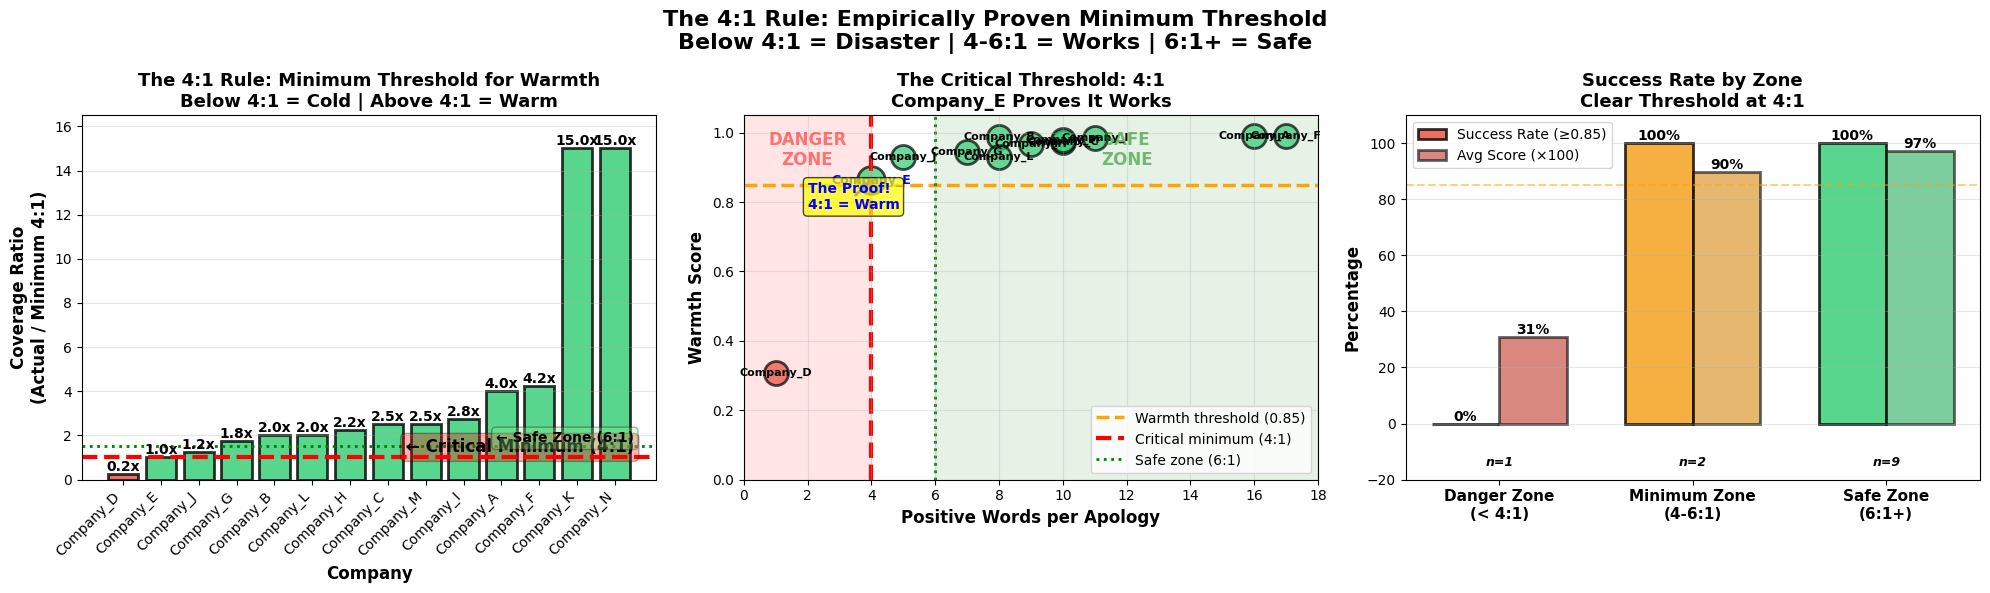


📊 SUMMARY: THE 4:1 THRESHOLD RULE

Company      Apologies  Positives  Ratio      Zone            Score      Result
--------------------------------------------------------------------------------
Company_F    1          17         17.0       ✅ SAFE          0.990      WARM
Company_A    1          16         16.0       ✅ SAFE          0.989      WARM
Company_B    2          16         8.0        ✅ SAFE          0.988      WARM
Company_I    1          11         11.0       ✅ SAFE          0.984      WARM
Company_M    1          10         10.0       ✅ SAFE          0.980      WARM
Company_C    1          10         10.0       ✅ SAFE          0.974      WARM
Company_H    1          9          9.0        ✅ SAFE          0.968      WARM
Company_G    1          7          7.0        ✅ SAFE          0.944      WARM
Company_J    1          5          5.0        ⚠️ MINIMUM      0.931      WARM
Company_L    1          8          8.0        ✅ SAFE          0.931      WARM
Company_E    1         

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_clean = df[df['status'] != 'ghosted'].copy()

df_clean['needed_minimum'] = df_clean['apology_words'] * 4  # 4:1 minimum!
df_clean['impact_ratio'] = df_clean['afinn_positive_count'] / df_clean['needed_minimum']
df_clean['impact_ratio'] = df_clean['impact_ratio'].replace([np.inf], 15)  # Cap for no apologies

df_clean = df_clean.sort_values('impact_ratio')

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ============ SUBPLOT 1: Ratio Bar Chart ============
ax1 = axes[0]

colors = ['#2ecc71' if ratio >= 1.0 else '#e74c3c' 
          for ratio in df_clean['impact_ratio']]

bars = ax1.bar(range(len(df_clean)), df_clean['impact_ratio'], 
              color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels
for i, (bar, ratio) in enumerate(zip(bars, df_clean['impact_ratio'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{ratio:.1f}x',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add threshold line at 1.0 (= 4:1 minimum)
ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=3)
ax1.text(len(df_clean)-0.5, 1.05, '← Critical Minimum (4:1)', 
        fontsize=12, ha='right', va='bottom', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

# Add safe zone line at 1.5 (= 6:1 safe zone)
ax1.axhline(y=1.5, color='green', linestyle=':', linewidth=2)
ax1.text(len(df_clean)-0.5, 1.55, '← Safe Zone (6:1)', 
        fontsize=10, ha='right', va='bottom', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

ax1.set_xlabel('Company', fontsize=12, fontweight='bold')
ax1.set_ylabel('Coverage Ratio\n(Actual / Minimum 4:1)', fontsize=12, fontweight='bold')
ax1.set_title('The 4:1 Rule: Minimum Threshold for Warmth\nBelow 4:1 = Cold | Above 4:1 = Warm',
             fontsize=13, fontweight='bold')
ax1.set_xticks(range(len(df_clean)))
ax1.set_xticklabels(df_clean['company_id'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, max(df_clean['impact_ratio']) * 1.1)

# ============ SUBPLOT 2: Scatter (Ratio vs Sentiment) ============
ax2 = axes[1]

with_apologies = df_clean[df_clean['apology_words'] > 0].copy()
with_apologies['positive_per_apology'] = (with_apologies['afinn_positive_count'] / 
                                          with_apologies['apology_words'])

for _, row in with_apologies.iterrows():
    color = '#2ecc71' if row['vader_compound'] >= 0.85 else '#e74c3c'
    size = 400 if row['company_id'] == 'Company_E' else 300  # Highlight Company_E!
    
    ax2.scatter(row['positive_per_apology'], row['vader_compound'],
               s=size, c=color, alpha=0.7, edgecolors='black', linewidth=2)
    
    # Special label for Company_E (the proof!)
    if row['company_id'] == 'Company_E':
        ax2.text(row['positive_per_apology'], row['vader_compound'],
                row['company_id'], fontsize=9, ha='center', va='center', 
                fontweight='bold', color='blue')
        ax2.annotate('The Proof!\n4:1 = Warm', 
                    xy=(row['positive_per_apology'], row['vader_compound']),
                    xytext=(2, 0.78),
                    fontsize=10, fontweight='bold', color='blue',
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
    else:
        ax2.text(row['positive_per_apology'], row['vader_compound'],
                row['company_id'], fontsize=8, ha='center', va='center', 
                fontweight='bold')

# Add threshold lines
ax2.axhline(y=0.85, color='orange', linestyle='--', linewidth=2.5,
           label='Warmth threshold (0.85)', zorder=1)
ax2.axvline(x=4, color='red', linestyle='--', linewidth=3,
           label='Critical minimum (4:1)', zorder=1)
ax2.axvline(x=6, color='green', linestyle=':', linewidth=2,
           label='Safe zone (6:1)', zorder=1)

# Shade the danger zone
ax2.axvspan(0, 4, alpha=0.1, color='red', zorder=0)
ax2.text(2, 0.95, 'DANGER\nZONE', ha='center', va='center',
        fontsize=12, fontweight='bold', color='red', alpha=0.5)

# Shade the safe zone
ax2.axvspan(6, 18, alpha=0.1, color='green', zorder=0)
ax2.text(12, 0.95, 'SAFE\nZONE', ha='center', va='center',
        fontsize=12, fontweight='bold', color='green', alpha=0.5)

ax2.set_xlabel('Positive Words per Apology', fontsize=12, fontweight='bold')
ax2.set_ylabel('Warmth Score', fontsize=12, fontweight='bold')
ax2.set_title('The Critical Threshold: 4:1\nCompany_E Proves It Works',
             fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(alpha=0.3)
ax2.set_xlim(0, 18)
ax2.set_ylim(0, 1.05)

# ============ SUBPLOT 3: The Three Zones ============
ax3 = axes[2]

# Calculate success rate by zone
df_analysis = df_clean[df_clean['apology_words'] > 0].copy()
df_analysis['ratio'] = df_analysis['afinn_positive_count'] / df_analysis['apology_words']

zones = {
    'Danger Zone\n(< 4:1)': df_analysis[df_analysis['ratio'] < 4],
    'Minimum Zone\n(4-6:1)': df_analysis[(df_analysis['ratio'] >= 4) & (df_analysis['ratio'] < 6)],
    'Safe Zone\n(6:1+)': df_analysis[df_analysis['ratio'] >= 6]
}

zone_names = list(zones.keys())
success_rates = []
counts = []
avg_scores = []

for zone_name, zone_df in zones.items():
    if len(zone_df) > 0:
        success_rate = (zone_df['vader_compound'] >= 0.85).sum() / len(zone_df) * 100
        success_rates.append(success_rate)
        counts.append(len(zone_df))
        avg_scores.append(zone_df['vader_compound'].mean())
    else:
        success_rates.append(0)
        counts.append(0)
        avg_scores.append(0)

x = np.arange(len(zone_names))
width = 0.35

# Bars for success rate
bars1 = ax3.bar(x - width/2, success_rates, width,
               label='Success Rate (≥0.85)', 
               color=['#e74c3c', '#f39c12', '#2ecc71'], 
               alpha=0.8, edgecolor='black', linewidth=2)

# Bars for average score (scaled to %)
bars2 = ax3.bar(x + width/2, [s*100 for s in avg_scores], width,
               label='Avg Score (×100)', 
               color=['#c0392b', '#d68910', '#27ae60'], 
               alpha=0.6, edgecolor='black', linewidth=2)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add counts
for i, count in enumerate(counts):
    ax3.text(i, -15, f'n={count}', ha='center', fontsize=9, 
            fontweight='bold', style='italic')

ax3.set_ylabel('Percentage', fontsize=12, fontweight='bold')
ax3.set_title('Success Rate by Zone\nClear Threshold at 4:1',
             fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(zone_names, fontsize=11, fontweight='bold')
ax3.legend(fontsize=10)
ax3.set_ylim(-20, 110)
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(y=85, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)

plt.suptitle('The 4:1 Rule: Empirically Proven Minimum Threshold\n' +
             'Below 4:1 = Disaster | 4-6:1 = Works | 6:1+ = Safe',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('../visualizations/4_to_1_threshold_analysis.png', dpi=300, bbox_inches='tight')
print("✅ 4:1 threshold analysis visualization saved!")
plt.show()

print("\n" + "="*80)
print("📊 SUMMARY: THE 4:1 THRESHOLD RULE")
print("="*80)
print(f"\n{'Company':<12} {'Apologies':<10} {'Positives':<10} {'Ratio':<10} "
      f"{'Zone':<15} {'Score':<10} {'Result'}")
print("-"*80)

for _, row in df_clean.sort_values('vader_compound', ascending=False).iterrows():
    if row['apology_words'] > 0:
        ratio = row['afinn_positive_count'] / row['apology_words']
        
        if ratio < 4:
            zone = "❌ DANGER"
            result = "COLD"
        elif ratio < 6:
            zone = "⚠️ MINIMUM"
            result = "WARM" if row['vader_compound'] >= 0.85 else "COOL"
        else:
            zone = "✅ SAFE"
            result = "WARM"
        
        print(f"{row['company_id']:<12} {int(row['apology_words']):<10} "
              f"{int(row['afinn_positive_count']):<10} {ratio:<10.1f} "
              f"{zone:<15} {row['vader_compound']:<10.3f} {result}")

